In [4]:
import yfinance as yf
import backtrader as bt
import talib
import numpy as np

# Fetch historical data for Tata Motors
tata = yf.Ticker("TATAMOTORS.BO")
data = tata.history(period="max")

# Define the custom Backtrader Strategy
class MyStrategy(bt.Strategy):
    params = (
        ("pattern_list", []),
    )
    
    def __init__(self):
        # Convert the data to NumPy arrays
        open_prices = np.array(self.data.open)
        high_prices = np.array(self.data.high)
        low_prices = np.array(self.data.low)
        close_prices = np.array(self.data.close)
        
        for pattern in self.params.pattern_list:
            pattern_func = getattr(talib, pattern)
            setattr(self, pattern, pattern_func(open_prices, high_prices, low_prices, close_prices))
            
    def next(self):
        for pattern in self.params.pattern_list:
            pattern_values = getattr(self, pattern)
            if pattern_values[-1] != 0:
                print(f"{pattern} pattern detected on {self.data.datetime.date(-1)}")

cerebro = bt.Cerebro()

# Add data feed to cerebro
data_feed = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data_feed)

# Add strategy to cerebro
pattern_list = [
    "CDL2CROWS",
    "CDL3BLACKCROWS",
    # ... (Add other pattern names here)
    "CDLTASUKIGAP",
]
cerebro.addstrategy(MyStrategy, pattern_list=pattern_list)

# Set initial cash and commission
cerebro.broker.set_cash(100000)  # Set an initial cash amount for backtesting
cerebro.broker.setcommission(commission=0.001)  # Set a simple commission rate

# Print starting cash amount
print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

# Run the backtest
cerebro.run()

# Print ending cash amount
print("Ending Portfolio Value: %.2f" % cerebro.broker.getvalue())


Starting Portfolio Value: 100000.00
Ending Portfolio Value: 100000.00


Starting Portfolio Value: 100000.00
Pattern CDLUPSIDEGAP2CROWS: [0 0 0 ... 0 0 0]
Ending Portfolio Value: 100000.00


<IPython.core.display.Javascript object>


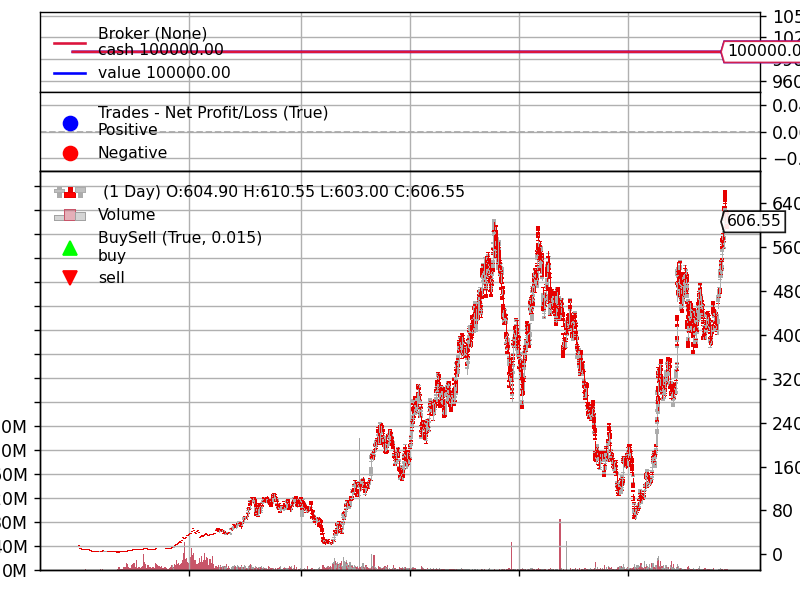

[[<Figure size 640x480 with 4 Axes>]]

In [15]:
import backtrader as bt
import talib
import numpy as np

class MyStrategy(bt.Strategy):
    params = (
        ("pattern_list", []),
        ("stop_loss_pct", 0.02),   # 2% stop loss
        ("take_profit_pct", 0.03), # 3% take profit
        ("min_pattern_confidence", 0),  # Minimum confidence level for pattern recognition
    )
    
    def __init__(self):
        self.trades = []
        
        # Convert the data to NumPy arrays
        open_prices = np.array(self.data.open)
        high_prices = np.array(self.data.high)
        low_prices = np.array(self.data.low)
        close_prices = np.array(self.data.close)
        
        for pattern in self.params.pattern_list:
            pattern_func = getattr(talib, pattern)
            try:
                pattern_values = pattern_func(open_prices, high_prices, low_prices, close_prices)
                print(f"Pattern {pattern}: {pattern_values}")
                setattr(self, pattern, pattern_values)
            except Exception as e:
                print(f"Error setting pattern {pattern}: {e}")
    
    def next(self):
        for pattern in self.params.pattern_list:
            pattern_values = getattr(self, pattern, None)
            if pattern_values is not None and pattern_values[-1] != 0 and pattern_values[-1] >= self.params.min_pattern_confidence:
                self.execute_trade(pattern)
    
    def execute_trade(self, pattern):
        if self.position:  # If there's an open position, close it first
            self.close()
        
        entry_price = self.data.close[0]
        stop_loss_price = entry_price * (1 - self.params.stop_loss_pct)
        take_profit_price = entry_price * (1 + self.params.take_profit_pct)
        
        trade = {
            "pattern": pattern,
            "entry_price": entry_price,
            "stop_loss_price": stop_loss_price,
            "take_profit_price": take_profit_price,
        }
        self.trades.append(trade)
        
        self.buy(price=entry_price, exectype=bt.Order.Market)
        self.sell(exectype=bt.Order.Stop, price=stop_loss_price)
        self.sell(exectype=bt.Order.Limit, price=take_profit_price)
    
    def stop(self):
        self.plot_trades()
    
    def plot_trades(self):
        for trade in self.trades:
            plot_color = 'g' if trade['entry_price'] < trade['take_profit_price'] else 'r'
            self.plotarrow(
                buy=trade['entry_price'],
                marker='^' if plot_color == 'g' else 'v',
                color=plot_color,
                size=12
            )

cerebro = bt.Cerebro()

# Add data feed to cerebro
data_feed = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data_feed)

# Add strategy to cerebro
pattern_list = [
    "CDLUPSIDEGAP2CROWS",  # Upside Gap Two Crows pattern
    # ... (Add other pattern names here)
]
cerebro.addstrategy(MyStrategy, pattern_list=pattern_list, min_pattern_confidence=50)  # Adjust min_pattern_confidence as needed

# Set initial cash and commission
cerebro.broker.set_cash(100000)  # Set an initial cash amount for backtesting
cerebro.broker.setcommission(commission=0.001)  # Set a simple commission rate

# Print starting cash amount
print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())

try:
    # Run the backtest
    cerebro.run()
except Exception as e:
    print(f"Error during backtest: {e}")

# Print ending cash amount
print("Ending Portfolio Value: %.2f" % cerebro.broker.getvalue())

# Plot the graph
cerebro.plot(style='candle')


In [1]:
import yfinance as yf
import backtrader as bt
import talib
import numpy as np
